In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer


In [50]:
df = pd.read_excel("pm10s_classes500m.xlsx")
print(df.head())

   Unnamed: 0       Data  Estacao id               Estacao       pm10  \
0           0 2018-06-20        1054          Anta-Espinho  13.681818   
1           1 2018-06-20        3093                 Arcos  36.491667   
2           2 2018-06-20        2017                Aveiro  27.125000   
3           3 2018-06-20        3075  Avenida da Liberdade  48.416667   
4           4 2018-06-20        1053               Avintes  27.200000   

   pm10_weighted Uso_solo_simplificado_500m  Urbanizado  Transporte  
0      20.646031                     Outros           0           0  
1      32.937641                 Urbanizado           1           0  
2      18.858698                 Urbanizado           1           0  
3      32.890849                 Transporte           0           1  
4      21.891247                     Outros           0           0  


In [51]:
#Covariancias
df["urban_pm10w"] = df["Urbanizado"] * df["pm10_weighted"]
df["transp_pm10w"] = df["Transporte"] * df["pm10_weighted"]
print(df.head())

   Unnamed: 0       Data  Estacao id               Estacao       pm10  \
0           0 2018-06-20        1054          Anta-Espinho  13.681818   
1           1 2018-06-20        3093                 Arcos  36.491667   
2           2 2018-06-20        2017                Aveiro  27.125000   
3           3 2018-06-20        3075  Avenida da Liberdade  48.416667   
4           4 2018-06-20        1053               Avintes  27.200000   

   pm10_weighted Uso_solo_simplificado_500m  Urbanizado  Transporte  \
0      20.646031                     Outros           0           0   
1      32.937641                 Urbanizado           1           0   
2      18.858698                 Urbanizado           1           0   
3      32.890849                 Transporte           0           1   
4      21.891247                     Outros           0           0   

   urban_pm10w  transp_pm10w  
0     0.000000      0.000000  
1    32.937641      0.000000  
2    18.858698      0.000000  
3     0.00

In [52]:
X_base = df[["pm10_weighted", "Urbanizado", "Transporte"]] #sem covariancias

X = df[[
    "pm10_weighted",
    "Urbanizado",
    "Transporte",
    "urban_pm10w",
    "transp_pm10w"
]]

y = df["pm10"]


# Convert to NumPy arrays for cross-validation
X_base_np = X_base.values
X_np = X.values
y_np = y.values


In [53]:
def full_lasso_diagnostics(X, y, alphas, cv_strategy, feature_names=None, label="model", plot=True):
    results = []
    y = np.asarray(y)
    X = np.asarray(X)

    for alpha in alphas:
        model = make_pipeline(
            ColumnTransformer([
            ('scale', StandardScaler(), [0]),  # only scale the first column
            (  'passthrough', 'passthrough', list(range(1, X.shape[1])))  # leave others as-is
            ]),
    Lasso(alpha=alpha, max_iter=10000)
)
        y_true_all, y_pred_all = [], []

        for train_idx, test_idx in cv_strategy.split(X):
            model.fit(X[train_idx], y[train_idx])
            y_pred = model.predict(X[test_idx])
            y_true_all.extend(y[test_idx])
            y_pred_all.extend(y_pred)

        r2 = r2_score(y_true_all, y_pred_all)
        rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
        mae = mean_absolute_error(y_true_all, y_pred_all)
        nonzero_count = np.sum(model.named_steps["lasso"].coef_ != 0)

        results.append({
            label: "with_cov" if X.shape[1] > 3 else "no_cov",
            "alpha": alpha,
            "r2": r2,
            "rmse": rmse,
            "mae": mae,
            "nonzero_features": nonzero_count
        })

    results_df = pd.DataFrame(results)
    best_row = results_df.sort_values("r2", ascending=False).iloc[0]
    best_alpha = best_row["alpha"]

    # Fit best model on all data
    final_model = make_pipeline(ColumnTransformer([
            ('scale', StandardScaler(), [0]),  # only scale the first column
            (  'passthrough', 'passthrough', list(range(1, X.shape[1])))  # leave others as-is
            ]), Lasso(alpha=best_alpha, max_iter=10000))
    final_model.fit(X, y)
    y_pred_full = final_model.predict(X)
    residuals = y - y_pred_full
    coefs = final_model.named_steps["lasso"].coef_

    if feature_names is None:
        feature_names = [f"x{i}" for i in range(X.shape[1])]

    if plot:
        # 1. R² and RMSE vs Alpha
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        sns.lineplot(data=results_df, x="alpha", y="r2", marker="o", ax=ax[0])
        ax[0].set_xscale("log")
        ax[0].set_title("R² vs Alpha")
        ax[0].grid(True)

        sns.lineplot(data=results_df, x="alpha", y="rmse", marker="o", ax=ax[1])
        ax[1].set_xscale("log")
        ax[1].set_title("RMSE vs Alpha")
        ax[1].grid(True)
        plt.tight_layout()
        plt.show()

        # 2. Residuals vs Predicted
        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=y_pred_full, y=residuals)
        plt.axhline(0, linestyle="--", color="gray")
        plt.title("Residuals vs Predicted")
        plt.xlabel("Predicted PM10")
        plt.ylabel("Residuals")
        plt.grid(True)
        plt.show()

        # 3. Histogram of Residuals
        plt.figure(figsize=(6, 4))
        sns.histplot(residuals, kde=True, bins=20)
        plt.title("Histogram of Residuals")
        plt.xlabel("Residual")
        plt.grid(True)
        plt.show()

        # 4. Actual vs Predicted
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y, y=y_pred_full)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
        plt.xlabel("Actual PM10")
        plt.ylabel("Predicted PM10")
        plt.title("Actual vs Predicted")
        plt.grid(True)
        plt.show()

        # 5. Coefficient Bar Chart
        plt.figure(figsize=(8, 4))
        sns.barplot(x=feature_names, y=coefs)
        plt.xticks(rotation=45)
        plt.title(f"Feature Coefficients (α={best_alpha:.2f})")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 6. Coefficient Paths
        coef_matrix = []
        path_alphas = np.arange(0.5, 10.5, 0.5)
        for a in path_alphas:
            m = make_pipeline(ColumnTransformer([
            ('scale', StandardScaler(), [0]),  # only scale the first column
            (  'passthrough', 'passthrough', list(range(1, X.shape[1])))  # leave others as-is
            ]), Lasso(alpha=a, max_iter=10000))
            m.fit(X, y)
            coef_matrix.append(m.named_steps["lasso"].coef_)
        coef_matrix = np.array(coef_matrix)

        plt.figure(figsize=(10, 6))
        for i in range(X.shape[1]):
            plt.plot(path_alphas, coef_matrix[:, i], label=feature_names[i])
        plt.xscale("log")
        plt.xlabel("Alpha (λ)")
        plt.ylabel("Coefficient")
        plt.title("Lasso Coefficient Paths")
        plt.axhline(0, linestyle="--", color="gray")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.grid(True)
        plt.show()

        # 7. Nonzero Feature Count vs Alpha
        plt.figure(figsize=(7, 4))
        sns.lineplot(data=results_df, x="alpha", y="nonzero_features", marker="o")
        plt.xscale("log")
        plt.title("Number of Nonzero Features vs Alpha")
        plt.grid(True)
        plt.show()

    print("Lasso regression (APLICADA AOS DADOS INTEIROS):")
    print(f"\nBest Alpha: {best_alpha:.2f}")
    print(f"R²:   {r2_score(y, y_pred_full):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred_full)):.3f}")
    print(f"MAE:  {mean_absolute_error(y, y_pred_full):.3f}")

    return {
        "best_model": final_model,
        "best_alpha": best_alpha,
        "results_df": results_df,
        "residuals": residuals,
        "coefficients": coefs
    }


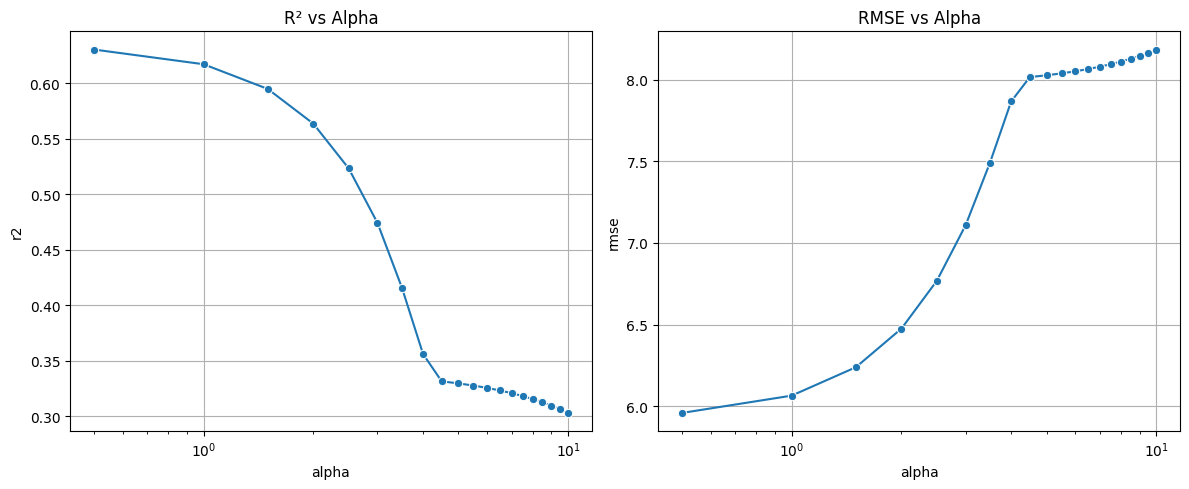

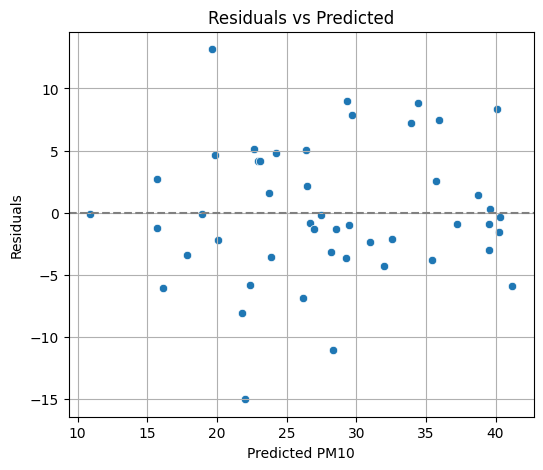

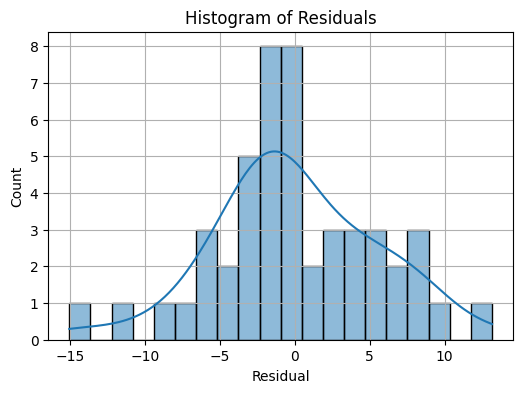

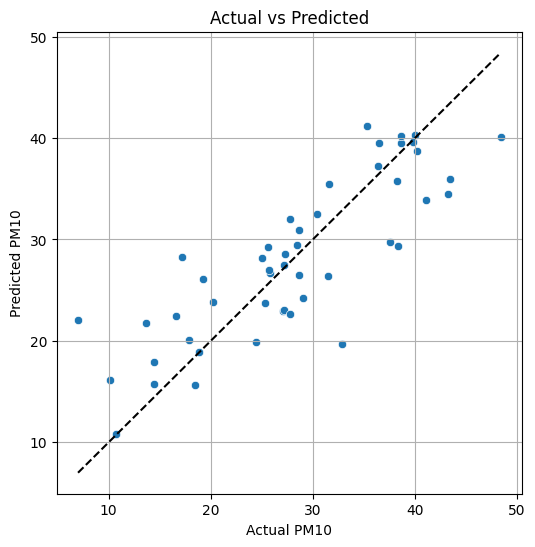

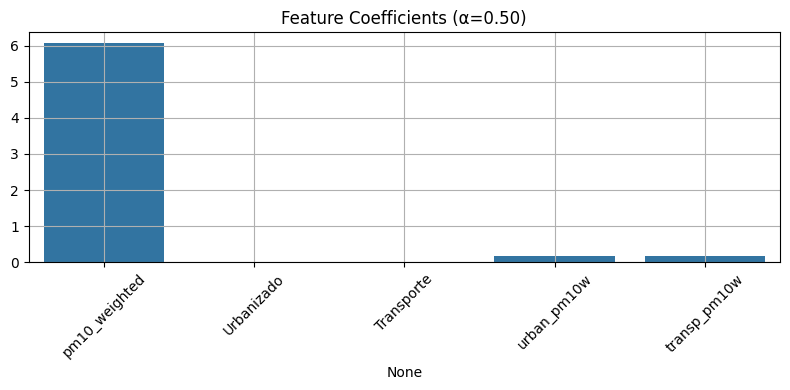

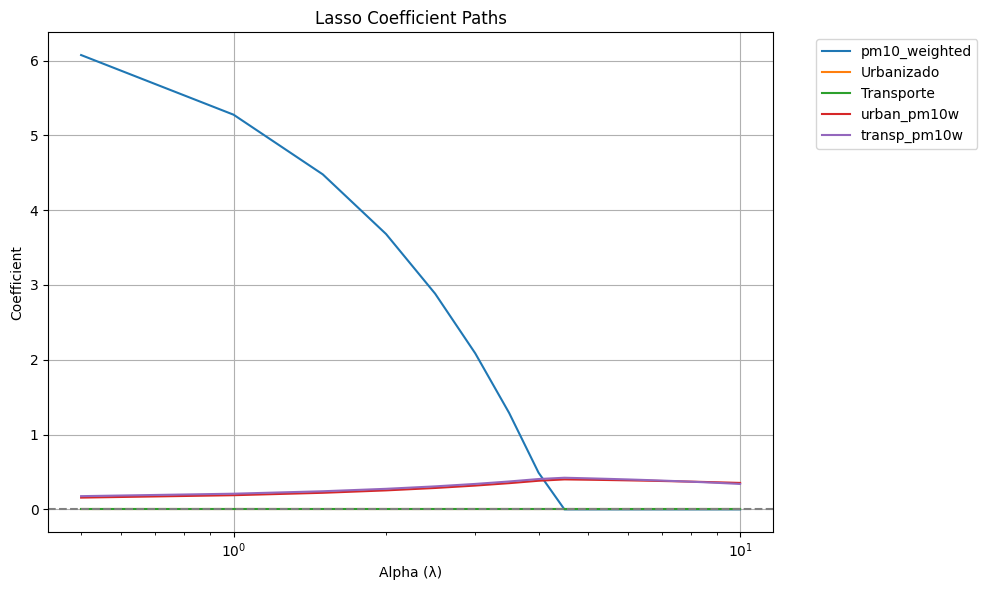

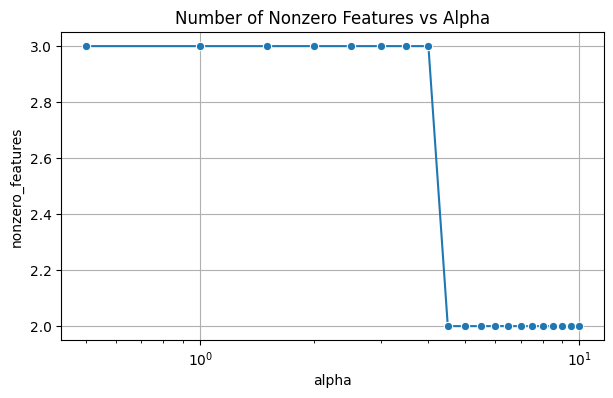

Lasso regression (APLICADA AOS DADOS INTEIROS):

Best Alpha: 0.50
R²:   0.695
RMSE: 5.416
MAE:  4.184
Cross-validated (TEST-ONLY) metrics for best alpha:
Alpha: 0.5
R²:    0.630
RMSE:  5.959
MAE:   4.584


In [54]:
alphas = np.arange(0.5, 10.5, 0.5)
cv = LeaveOneOut()
#cv = KFold(n_splits=5, shuffle=True, random_state=42)

result = full_lasso_diagnostics(
    X=X.values,
    y=y.values,
    alphas=alphas,
    cv_strategy=cv,
    feature_names=X.columns,
    plot=True
)

results_df = result["results_df"]
best_alpha_row = results_df.sort_values("r2", ascending=False).iloc[0]
print("Cross-validated (TEST-ONLY) metrics for best alpha:")
print(f"Alpha: {best_alpha_row['alpha']}")
print(f"R²:    {best_alpha_row['r2']:.3f}")
print(f"RMSE:  {best_alpha_row['rmse']:.3f}")
print(f"MAE:   {best_alpha_row['mae']:.3f}")

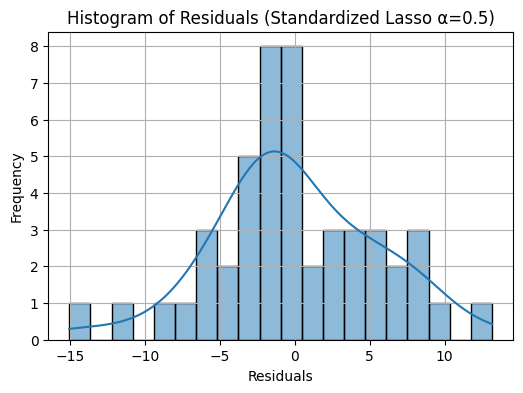

True

In [55]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), [0]),                      # scale only pm10_weighted
    ('passthrough', 'passthrough', list(range(1, X.shape[1])))  # leave others unscaled
])
model = make_pipeline(preprocessor, Lasso(alpha=0.5, max_iter=10000))
model.fit(X, y)
y_pred = model.predict(X)
residuals_1 = y - y_pred



plt.figure(figsize=(6, 4))
sns.histplot(residuals_1, kde=True, bins=20)
plt.title("Histogram of Residuals (Standardized Lasso α=0.5)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

np.allclose(residuals_1, residuals)


In [57]:
# Extract Lasso from the pipeline
lasso = model.named_steps['lasso']
coefs_scaled = lasso.coef_
intercept_scaled = lasso.intercept_

# Print scaled equation
feature_names = X.columns
terms = [f"{coef:.3f}*{name}" for coef, name in zip(coefs_scaled, feature_names)]
equation_scaled = " + ".join(terms) + f" + {intercept_scaled:.3f}"
print("Scaled equation:\n", equation_scaled)


Scaled equation:
 6.074*pm10_weighted + -0.000*Urbanizado + -0.000*Transporte + 0.158*urban_pm10w + 0.177*transp_pm10w + 25.708


In [59]:
# Extract scalers from the ColumnTransformer
column_transformer = model.named_steps['columntransformer']
scaler = column_transformer.named_transformers_['scale']

scale_mean = scaler.mean_[0]
scale_std = scaler.scale_[0]

# Unscale only the first coefficient
coefs_unscaled = coefs_scaled.copy()
coefs_unscaled[0] = coefs_scaled[0] / scale_std  # rescale first column
# Others are untouched because they weren't scaled

# Fix intercept
intercept_unscaled = intercept_scaled - (coefs_scaled[0] * scale_mean / scale_std)

# Build readable equation
terms_unscaled = [f"{coef:.3f}*{name}" for coef, name in zip(coefs_unscaled, feature_names)]
equation_unscaled = " + ".join(terms_unscaled) + f" + {intercept_unscaled:.3f}"
print("Unscaled equation:\n", equation_unscaled)

Unscaled equation:
 1.018*pm10_weighted + -0.000*Urbanizado + -0.000*Transporte + 0.158*urban_pm10w + 0.177*transp_pm10w + 0.773
